In [1]:
# Install Streamlit and pyngrok to run Streamlit in Colab
!pip install streamlit -q
!pip install pyngrok -q
!pip install scikit-learn pandas numpy matplotlib seaborn -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 89.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 117.9 MB/s eta 0:00:00


In [ ]:
#########################################################################################################################
######## This Code Made by WISAM kakooz for 2025 NASA Space Apps Challenge | A World Away: Hunting for Exoplanets with AI 
#########################################################################################################################

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score
import joblib

pd.set_option('display.max_columns', None)

# ----------------------------
# 1️ Load datasets
# ----------------------------
urls = {
    "KOI": "https://raw.githubusercontent.com/MatiasPF1/KOI-Dataset/main/NasaDataset.csv",
    "TOI": "https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+*+from+toi&format=csv",
    "CUMULATIVE": "https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+*+from+cumulative&format=csv",
    "K2": "https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+*+from+k2pandc&format=csv"
}

dfs = {}
for name, url in urls.items():
    try:
        dfs[name] = pd.read_csv(url, low_memory=False)
        print(f"Loaded {name}: {dfs[name].shape}")
    except Exception as e:
        print(f"Failed to load {name}: {e}")

# ----------------------------
# 2️ Define unified feature mapping
# ----------------------------
feature_map = {
    'period': {'KOI':'koi_period', 'TOI':'toi_period', 'CUMULATIVE':'koi_period', 'K2':'k2_period'},
    'duration': {'KOI':'koi_duration', 'TOI':'toi_duration', 'CUMULATIVE':'koi_duration', 'K2':'k2_duration'},
    'depth': {'KOI':'koi_depth', 'TOI':'toi_depth', 'CUMULATIVE':'koi_depth', 'K2':'k2_depth'},
    'planet_radius': {'KOI':'koi_prad', 'TOI':'toi_prad', 'CUMULATIVE':'koi_prad', 'K2':'k2_prad'},
    'stellar_radius': {'KOI':'koi_srad', 'TOI':'toi_srad', 'CUMULATIVE':'koi_srad', 'K2':'k2_srad'},
    'stellar_mass': {'KOI':'koi_smass', 'TOI':'toi_smass', 'CUMULATIVE':'koi_smass', 'K2':'k2_smass'},
    'snr': {'KOI':'koi_model_snr', 'TOI':'toi_model_snr', 'CUMULATIVE':'koi_model_snr', 'K2':'k2_snr'},
    'fpflag_nt': {'KOI':'koi_fpflag_nt', 'TOI':'toi_fpflag_nt', 'CUMULATIVE':'koi_fpflag_nt', 'K2':'k2_fpflag_nt'},
    'fpflag_ss': {'KOI':'koi_fpflag_ss', 'TOI':'toi_fpflag_ss', 'CUMULATIVE':'koi_fpflag_ss', 'K2':'k2_fpflag_ss'},
    'fpflag_co': {'KOI':'koi_fpflag_co', 'TOI':'toi_fpflag_co', 'CUMULATIVE':'koi_fpflag_co', 'K2':'k2_fpflag_co'},
    'fpflag_ec': {'KOI':'koi_fpflag_ec', 'TOI':'toi_fpflag_ec', 'CUMULATIVE':'koi_fpflag_ec', 'K2':'k2_fpflag_ec'}
}

target_map = {
    'KOI':'koi_disposition',
    'TOI':'tfopwg_disp',
    'CUMULATIVE':'koi_disposition',
    'K2':'disposition'
}

# Label standardization
label_standard = {'CONFIRMED':'CONFIRMED', 'CANDIDATE':'CANDIDATE', 'PC':'CANDIDATE', 'CP':'CONFIRMED', 'FALSE POSITIVE':'FALSE POSITIVE', 'FP':'FALSE POSITIVE'}

# ----------------------------
# 3️ Function to unify dataset
# ----------------------------
def unify_dataset(df, dataset_name):
    # Select only available columns
    unified_df = pd.DataFrame()
    for unified_col, mapping in feature_map.items():
        raw_col = mapping.get(dataset_name)
        if raw_col in df.columns:
            unified_df[unified_col] = pd.to_numeric(df[raw_col], errors='coerce')
        else:
            unified_df[unified_col] = np.nan
    # Process target
    target_col = target_map[dataset_name]
    if target_col in df.columns:
        unified_df['label_raw'] = df[target_col].map(str).map(lambda x: label_standard.get(x.strip(), np.nan))
    else:
        unified_df['label_raw'] = np.nan
    # Drop rows missing features or label
    unified_df = unified_df.dropna()
    return unified_df

# ----------------------------
# 4️ Merge all datasets
# ----------------------------
all_dfs = []
for name in dfs.keys():
    unified = unify_dataset(dfs[name], name)
    all_dfs.append(unified)

df_all = pd.concat(all_dfs, ignore_index=True)
print(f"Unified dataset shape: {df_all.shape}")
print(df_all['label_raw'].value_counts())

# ----------------------------
# 5️ Encode target
# ----------------------------
le = LabelEncoder()
df_all['label'] = le.fit_transform(df_all['label_raw'])
features = list(feature_map.keys())

# ----------------------------
# 6️ Split data
# ----------------------------
X = df_all[features]
y = df_all['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ----------------------------
# 7️ Train model
# ----------------------------
clf = RandomForestClassifier(n_estimators=300, max_depth=15, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

# ----------------------------
# 8️ Evaluate
# ----------------------------
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

# ----------------------------
# 9️ Save pipeline
# ----------------------------
joblib.dump({
    "model": clf,
    "scaler": scaler,
    "label_encoder": le,
    "features": features
}, "unified_exoplanet_model.pkl")

print("Unified model saved as 'unified_exoplanet_model.pkl'")


Loaded KOI: (9564, 49)
Loaded TOI: (7703, 91)
Loaded CUMULATIVE: (9564, 153)
Loaded K2: (4004, 361)
Unified dataset shape: (9201, 12)
label_raw
FALSE POSITIVE    4582
CONFIRMED         2744
CANDIDATE         1875
Name: count, dtype: int64
Accuracy: 0.9250407387289517
                precision    recall  f1-score   support

     CANDIDATE       0.81      0.84      0.82       375
     CONFIRMED       0.89      0.88      0.88       549
FALSE POSITIVE       1.00      0.99      0.99       917

      accuracy                           0.93      1841
     macro avg       0.90      0.90      0.90      1841
  weighted avg       0.93      0.93      0.93      1841

Unified model saved as 'unified_exoplanet_model.pkl'


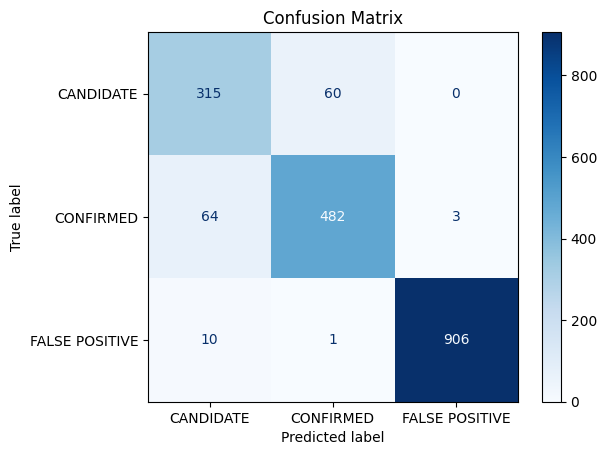

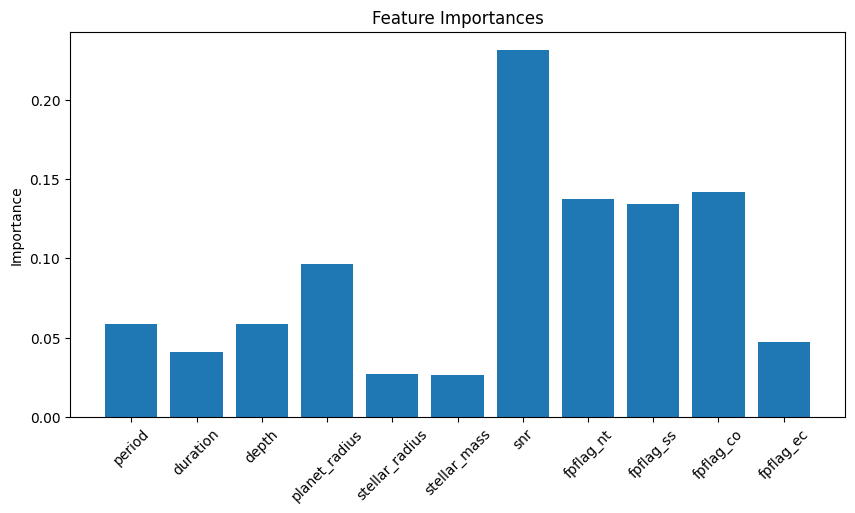

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Optional: plot feature importances
importances = clf.feature_importances_
plt.figure(figsize=(10,5))
plt.bar(features, importances)
plt.xticks(rotation=45)
plt.title("Feature Importances")
plt.ylabel("Importance")
plt.show()


Cross-validation scores: [0.85388376 0.92336957 0.93804348 0.96304348 0.86630435]
Mean accuracy: 0.9089289256783883


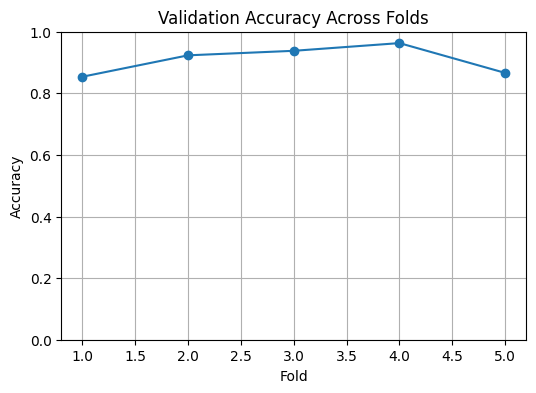

In [7]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np

# 5-fold cross-validation
scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
print("Cross-validation scores:", scores)
print("Mean accuracy:", scores.mean())

# Plot
plt.figure(figsize=(6,4))
plt.plot(range(1, 6), scores, marker='o', linestyle='-')
plt.title("Validation Accuracy Across Folds")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.grid(True)
plt.show()


In [8]:
from google.colab import files

# The model is already saved as 'unified_exoplanet_model.pkl'
files.download("unified_exoplanet_model.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>